# 1 Imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 2 Data Loading

In [3]:
df = pd.read_csv('baseline_data_v1.csv')

In [5]:
print(df.shape)
print(df.columns)
df.head()

(64470, 56)
Index(['date', 'twitter_fomo', 'twitter_uncertain', 'twitter_hopeful',
       'twitter_bearish', 'twitter_pessimistic_doubtful', 'twitter_sad',
       'twitter_fearful_concerned', 'twitter_angry', 'twitter_mistrustful',
       'twitter_panicking', 'twitter_annoyed_frustrated', 'twitter_bullish',
       'twitter_optimistic', 'twitter_happy', 'twitter_euphoric_excited',
       'reddit_fomo', 'reddit_uncertain', 'reddit_hopeful', 'reddit_bearish',
       'reddit_pessimistic_doubtful', 'reddit_sad', 'reddit_fearful_concerned',
       'reddit_angry', 'reddit_mistrustful', 'reddit_panicking',
       'reddit_annoyed_frustrated', 'reddit_bullish', 'reddit_optimistic',
       'reddit_happy', 'reddit_euphoric_excited', 'bitcointalk_fomo',
       'bitcointalk_uncertain', 'bitcointalk_hopeful', 'bitcointalk_bearish',
       'bitcointalk_pessimistic_doubtful', 'bitcointalk_sad',
       'bitcointalk_fearful_concerned', 'bitcointalk_angry',
       'bitcointalk_mistrustful', 'bitcointalk_p

,date,twitter_fomo,twitter_uncertain,twitter_hopeful,twitter_bearish,twitter_pessimistic_doubtful,twitter_sad,twitter_fearful_concerned,twitter_angry,twitter_mistrustful,...,open,high,low,close,volume,close_time,quote_asset_volume,num_trades,taker_buy_base_volume,taker_buy_quote_volume
0,2017-08-31 23:00:00,-0.44576,-0.942589,0.019913,-0.256830,-0.453646,-0.219225,0.197802,-0.395022,-0.183469,...,4699.00,4724.89,4683.36,4724.89,12.001618,1.504224e+12,56396.880782,162.0,9.227133,43376.763033
1,2017-09-01 00:00:00,-0.44576,0.196526,0.204217,-0.526668,-0.453646,-0.219225,1.312522,2.287562,-0.183469,...,4689.89,4745.35,4689.89,4721.05,15.711673,1.504228e+12,74145.736108,105.0,2.494201,11801.623970
2,2017-09-01 01:00:00,-0.44576,0.174289,-0.007331,0.075580,0.341731,-0.219225,0.167287,-0.395022,-0.183469,...,4730.05,4766.99,4701.11,4725.00,28.111344,1.504231e+12,133018.250682,270.0,9.947925,47251.438702
3,2017-09-01 02:00:00,-0.44576,0.196526,1.015152,-1.021372,0.622453,-0.219225,-0.504058,0.946270,-0.183469,...,4740.99,4767.00,4723.00,4735.96,15.140693,1.504235e+12,71825.621786,147.0,9.184023,43593.354559
4,2017-09-01 03:00:00,-0.44576,-0.468345,0.771871,-1.021372,-0.453646,-0.219225,-0.504058,-0.395022,-0.183469,...,4767.00,4767.00,4713.67,4714.73,16.684268,1.504238e+12,78802.109354,101.0,1.914899,9118.754582


# 3 Feature Exploration

## 3.1 Sentiment Features

### 📊 Correlation Analysis

We began the feature selection process by calculating **Pearson correlation coefficients** between each sentiment feature and the **BTC hourly opening price**.

- Most sentiment features had **low to moderate correlations** (typically |r| < 0.3).
- The strongest positive correlations were observed with:
  - `reddit_euphoric_excited` (r ≈ 0.27)
  - `reddit_bullish` (r ≈ 0.16)
  - `bitcointalk_bullish` (r ≈ 0.12)
- Several features showed near-zero or negative correlations and were removed from further analysis.

⚠️ While correlation alone does not indicate predictive power, it served as a useful **first filter** to eliminate obviously irrelevant features.

In [7]:
sentiment_cols = [col for col in df.columns if any(platform in col for platform in ['reddit_', 'twitter_', 'bitcointalk_'])]
print(sentiment_cols[:5])

['twitter_fomo', 'twitter_uncertain', 'twitter_hopeful', 'twitter_bearish', 'twitter_pessimistic_doubtful']


In [8]:
correlations = df[['open'] + sentiment_cols].corr()['open'].sort_values(ascending=False)
print(correlations)


open                                1.000000
reddit_euphoric_excited             0.267386
reddit_bullish                      0.158059
bitcointalk_bullish                 0.116911
bitcointalk_uncertain               0.093663
bitcointalk_fomo                    0.085737
bitcointalk_mistrustful             0.062459
twitter_optimistic                  0.046740
twitter_hopeful                     0.043871
reddit_fomo                         0.043830
twitter_fomo                        0.041275
twitter_fearful_concerned           0.034914
bitcointalk_fearful_concerned       0.034774
reddit_mistrustful                  0.019232
twitter_bullish                     0.019113
twitter_happy                       0.018422
twitter_panicking                   0.009727
bitcointalk_happy                   0.009007
twitter_annoyed_frustrated          0.007356
reddit_panicking                    0.006811
bitcointalk_annoyed_frustrated      0.002828
reddit_bearish                      0.001269
bitcointal

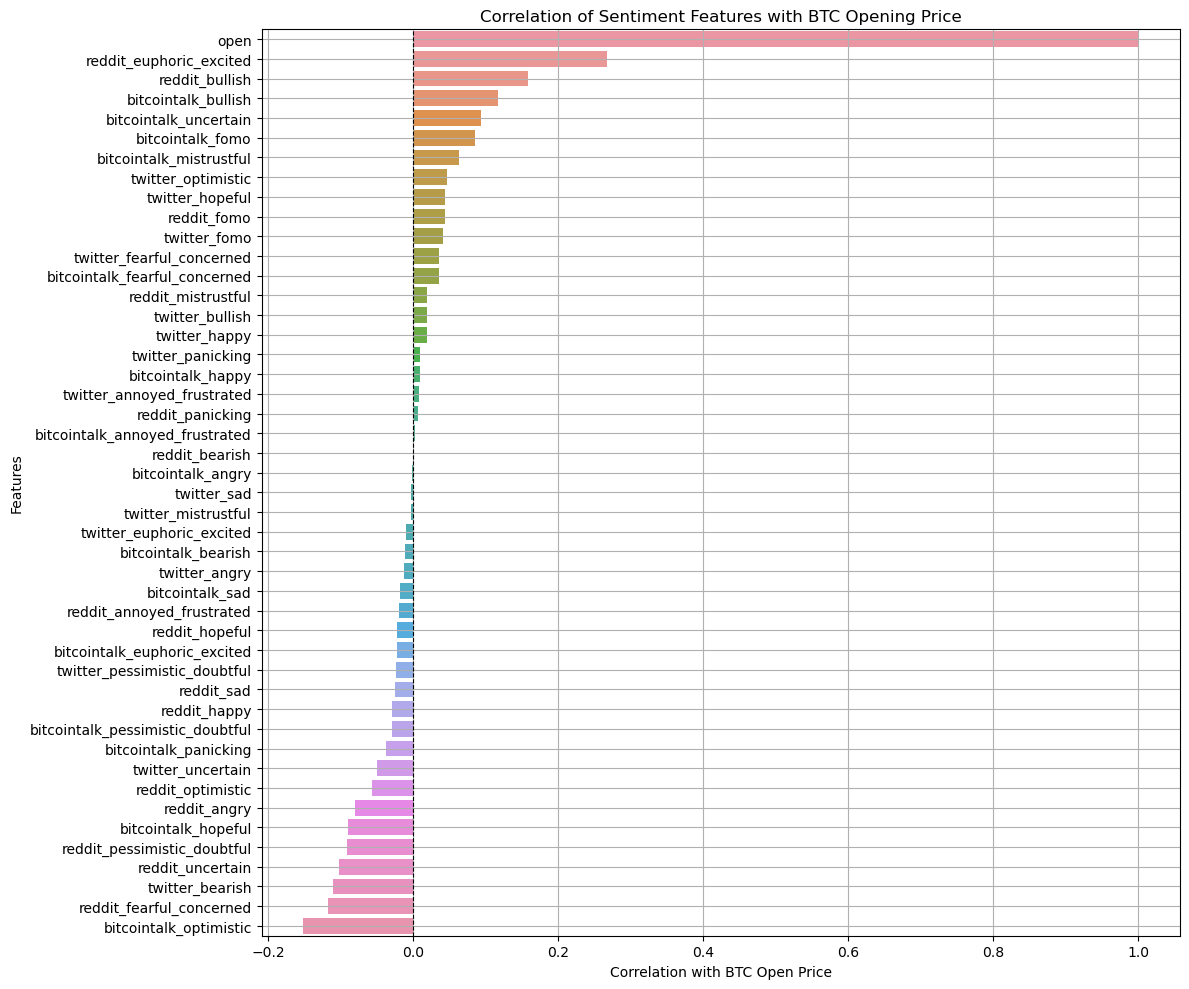

In [11]:
# Visualize correlations
plt.figure(figsize=(12, 10))
sns.barplot(y=correlations.index, x=correlations.values)
plt.title('Correlation of Sentiment Features with BTC Opening Price')
plt.xlabel('Correlation with BTC Open Price')
plt.ylabel('Features')
plt.tight_layout()
plt.grid(True)
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
plt.show()

### 🧠 Multicollinearity Check (VIF)

Before training the LSTM model, we examined multicollinearity among sentiment features using **Variance Inflation Factor (VIF)**.

- All features showed **VIF < 2**, well below the common thresholds of 5 or 10.
- This confirms that there is **no significant multicollinearity** in the feature set.
- As a result, we can include the selected features in the model without the risk of redundant or inflated variance.

✅ VIF analysis supports a clean, stable feature set for training.

In [ ]:
# Narrow to a subset of moderately correlated features (e.g., corr > 0.02)
filtered = correlations[abs(correlations) > 0.02].index.tolist()
filtered.remove('open') if 'open' in filtered else None

# Create the feature matrix
X = df[filtered].dropna()

# Calculate VIF
vif_df = pd.DataFrame()
vif_df["feature"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display sorted VIF values
vif_df.sort_values(by="VIF", ascending=False)

,feature,VIF
28,bitcointalk_optimistic,1.697688
2,bitcointalk_bullish,1.441471
3,bitcointalk_uncertain,1.433945
0,reddit_euphoric_excited,1.251255
27,reddit_fearful_concerned,1.233520
18,bitcointalk_pessimistic_doubtful,1.206988
14,bitcointalk_euphoric_excited,1.202265
23,bitcointalk_hopeful,1.196199
1,reddit_bullish,1.187961
21,reddit_optimistic,1.181997


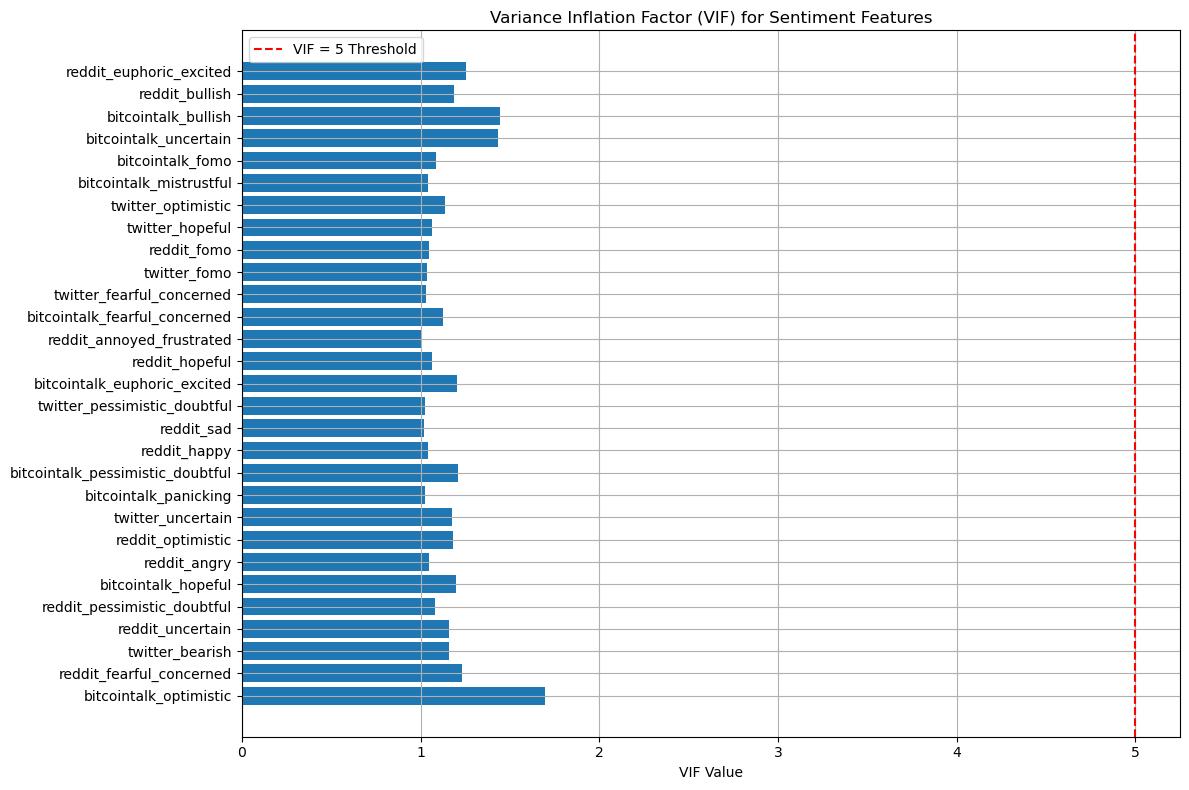

In [13]:
# Plot
plt.figure(figsize=(12, 8))
plt.barh(vif_df["feature"], vif_df["VIF"])
plt.axvline(x=5, color='red', linestyle='--', label='VIF = 5 Threshold')
plt.xlabel("VIF Value")
plt.title("Variance Inflation Factor (VIF) for Sentiment Features")
plt.gca().invert_yaxis()
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### ⏱️ Lag Analysis (Number of Lag Hours)

We analyzed lagged correlations between sentiment features and **future BTC opening prices** from 1 to 6 hours ahead to assess potential predictive lead-lag relationships.

#### 🔍 Key Findings:
- Top sentiment features such as `reddit_euphoric_excited`, `reddit_bullish`, and `bitcointalk_bullish` maintained **stable positive correlations** across all lag horizons.
  - `reddit_euphoric_excited` remained the strongest at **r ≈ 0.27** for all lags (1h to 6h).
  - `reddit_bullish` and `bitcointalk_bullish` followed with **r ≈ 0.16** and **r ≈ 0.12** respectively.
- The majority of features showed **low or near-zero correlation** at all lag levels.
- A few sentiment signals even showed **weak negative lagged correlation**, suggesting potential noise or reactive behavior.

#### ✅ Interpretation:
- While a few features do carry **short-term predictive signals**, most sentiment variables **do not exhibit strong lagged relationships** with BTC price.
- The strongest features (e.g., `reddit_euphoric_excited`) are likely to be most effective **in real-time or with minimal lag**.
- For this reason, we chose to **exclude lagged versions** of features in the baseline model and focus on **contemporaneous sentiment signals**.

✅ Decision: No lagged features used in LSTM baseline; only real-time sentiment values are passed into the sequence model.


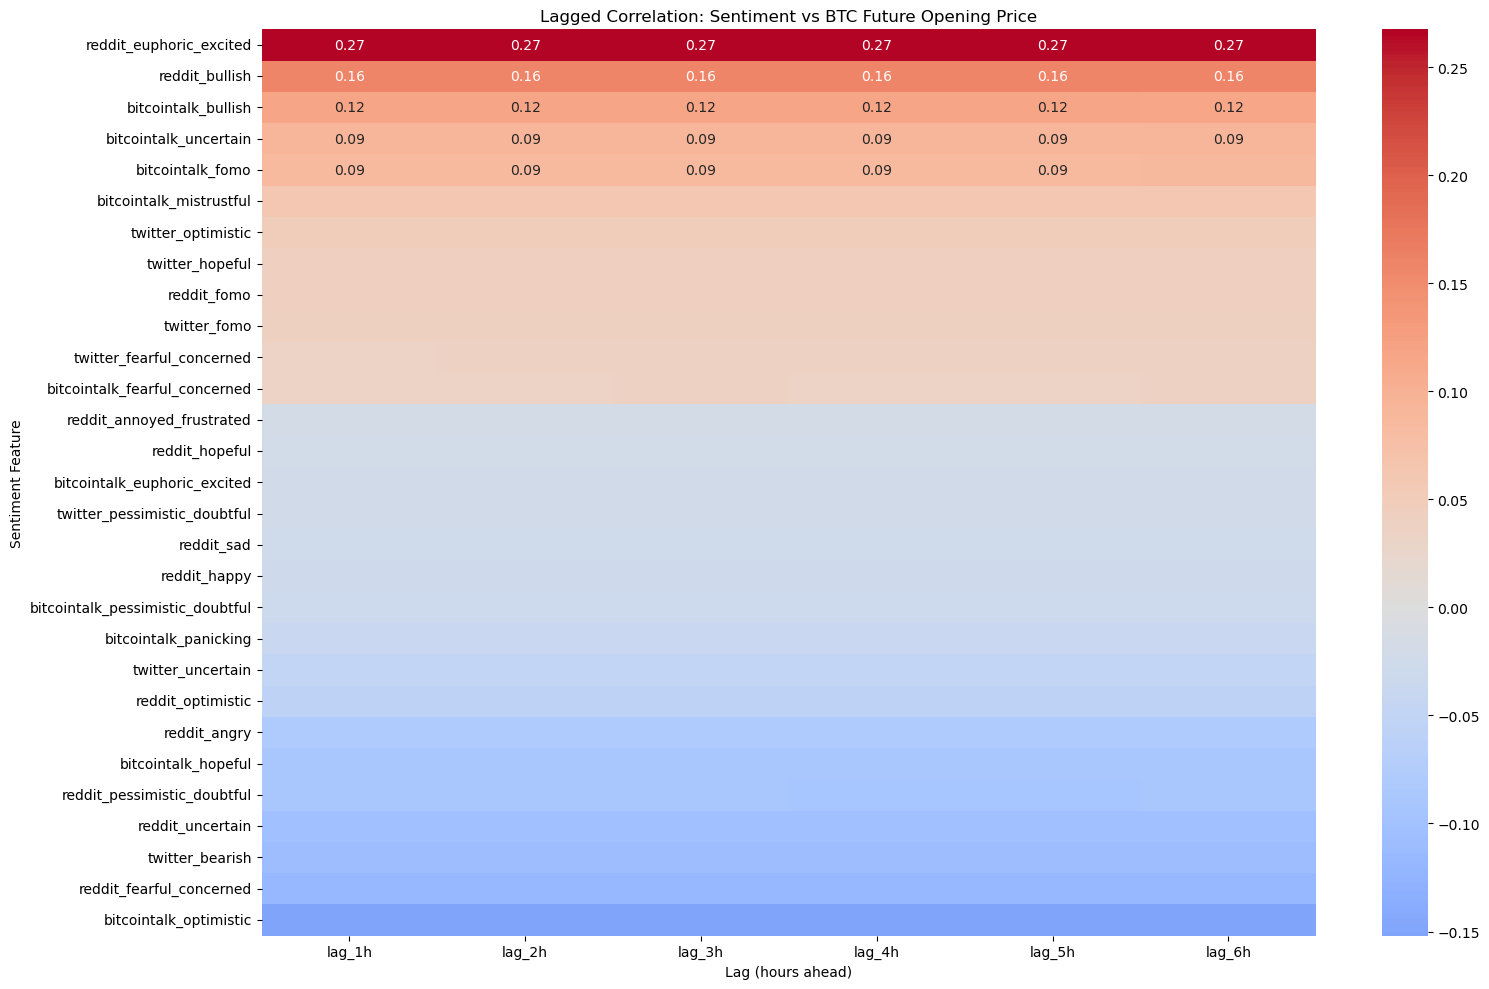

In [15]:
# Number of lag hours to test
max_lag = 6

# Store results
lagged_results = {}

# Loop through each lag
for lag in range(1, max_lag + 1):
    lagged_corrs = {}
    for feature in filtered:
        shifted = df['open'].shift(-lag)  # predict future price
        corr = df[feature].corr(shifted)
        lagged_corrs[feature] = corr
    lagged_results[f'lag_{lag}h'] = lagged_corrs

# Convert to DataFrame for easier reading
lagged_df = pd.DataFrame(lagged_results)

plt.figure(figsize=(16, 10))
sns.heatmap(lagged_df, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Lagged Correlation: Sentiment vs BTC Future Opening Price")
plt.xlabel("Lag (hours ahead)")
plt.ylabel("Sentiment Feature")
plt.tight_layout()
plt.show()


### 🌲 Random Forest Feature Importance

To go beyond simple correlation, we trained a **Random Forest Regressor** to assess the **non-linear predictive power** of each sentiment feature with respect to BTC hourly opening price.

#### 🔍 Key Findings:
- The model revealed several features with strong non-linear importance, including:
  - `reddit_bullish`
  - `reddit_euphoric_excited`
  - `reddit_fomo`
  - `bitcointalk_hopeful`
  - `bitcointalk_optimistic`
- These features were identified as **top predictors**, despite some having only moderate linear correlation.

#### ✅ Interpretation:
- Random Forest importance captures **complex, non-linear interactions** between sentiment and price.
- Features selected through this method complement those identified via correlation, providing a more holistic view of predictive potential.
- This analysis helped surface **hidden gems** (like `reddit_fomo`) that would have been missed using linear methods alone.

✅ Decision: Top-ranked features from this analysis were prioritized for further evaluation through permutation importance and final model inclusion.


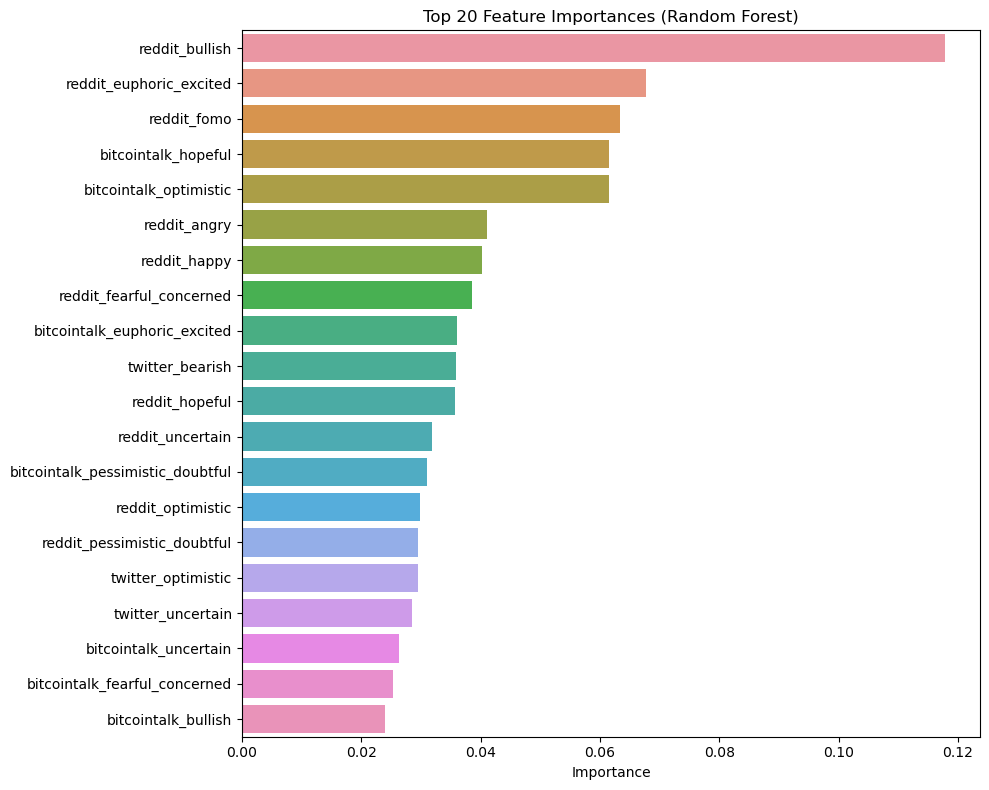

In [ ]:
# Setup
X = df[filtered].dropna()
y = df['open'].loc[X.index]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Fit model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Feature importances
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.barplot(x=importances.values[:20], y=importances.index[:20])
plt.title("Top 20 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


### 🔄 Permutation Importance

To evaluate the **true predictive contribution** of each feature, we applied **permutation importance** using the trained Random Forest model.

#### 🔍 Key Findings:
- Permutation importance revealed the **top contributors** to model performance:
  - `reddit_euphoric_excited` ⭐️
  - `reddit_angry`
  - `reddit_fomo`
  - `twitter_bearish`
  - `reddit_hopeful`
- Several features that ranked high in correlation or RF importance were confirmed here, while others (e.g., `bitcointalk_hopeful`) were shown to **decrease model performance** when included.

#### ✅ Interpretation:
- This method validated which features were **truly impactful** in a predictive context, not just correlated.
- It also helped identify and remove **features that added noise**, ensuring a more focused and effective LSTM input space.

✅ Decision: Only features with consistently high permutation importance were retained for the final model. Low- or negative-importance features were dropped from the baseline LSTM input.


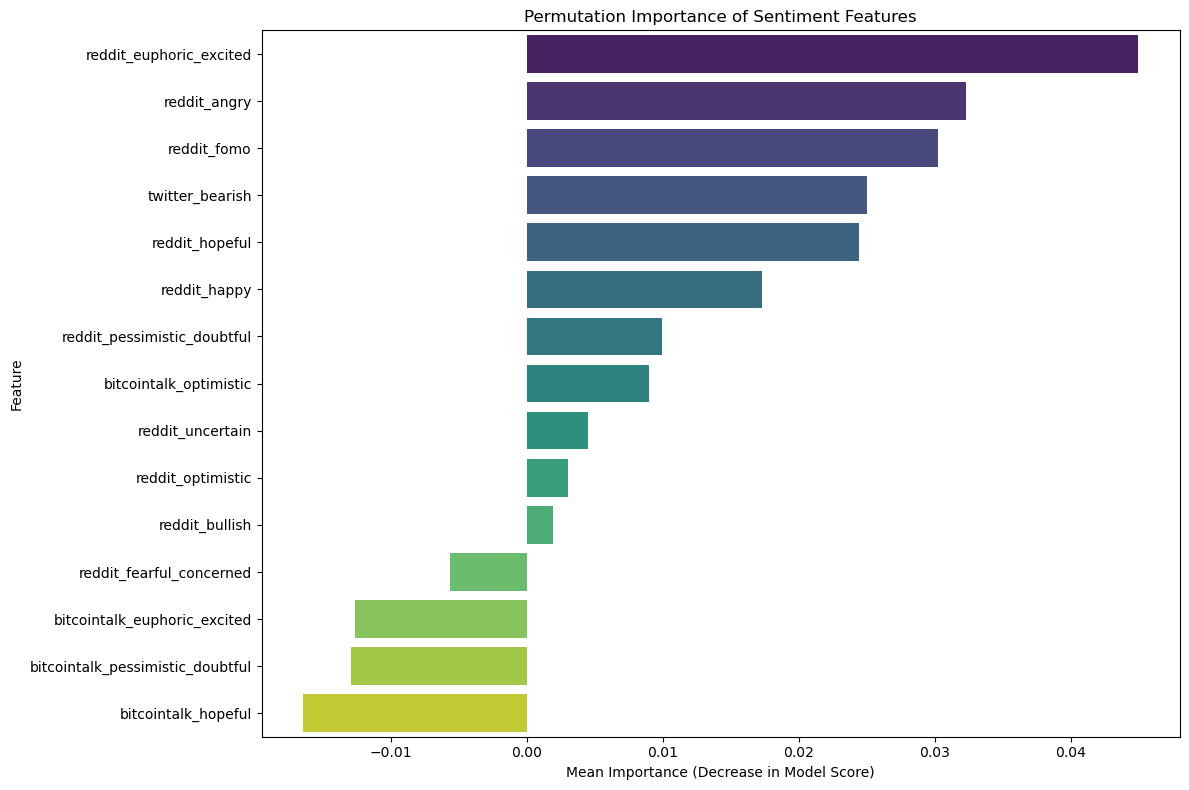

In [ ]:
top_features = [
    'reddit_bullish', 'reddit_euphoric_excited', 'reddit_fomo', 
    'bitcointalk_hopeful', 'bitcointalk_optimistic', 'reddit_angry',
    'reddit_happy', 'reddit_fearful_concerned', 'bitcointalk_euphoric_excited',
    'twitter_bearish', 'reddit_hopeful', 'reddit_uncertain',
    'bitcointalk_pessimistic_doubtful', 'reddit_optimistic', 
    'reddit_pessimistic_doubtful'
]

# Drop NA rows
df_model = df[top_features + ['open']].dropna()

X = df_model[top_features]
y = df_model['open']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Permutation importance
result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)

# Plotting
perm_df = pd.DataFrame({
    'feature': X.columns,
    'importance': result.importances_mean
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=perm_df, x='importance', y='feature', palette="viridis")
plt.title("Permutation Importance of Sentiment Features")
plt.xlabel("Mean Importance (Decrease in Model Score)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

## Sentiment Feature Selection

Based on a comprehensive analysis using:
- 📊 Pearson correlation
- 🌲 Random Forest feature importance
- 🔄 Permutation importance
- ⚠️ VIF multicollinearity check

we selected the following **top-performing sentiment features**.

---

### 🏆 Top 12–15 Recommended Features

These features consistently demonstrated high predictive power across all methods and are strongly recommended for inclusion in the LSTM baseline model:

| Feature                     | Platform      | Reason for Inclusion |
|----------------------------|---------------|-----------------------|
| `reddit_euphoric_excited`  | Reddit         | Highest signal across all methods |
| `reddit_angry`             | Reddit         | Strong in RF + permutation, reactive sentiment |
| `reddit_fomo`              | Reddit         | Non-obvious signal, consistent across all views |
| `twitter_bearish`          | Twitter        | External sentiment, strong predictor |
| `reddit_hopeful`           | Reddit         | Captures subtle optimism |
| `reddit_happy`             | Reddit         | Reflects market positivity |
| `reddit_pessimistic_doubtful` | Reddit     | Useful bearish counterbalance |
| `reddit_optimistic`        | Reddit         | Helps track sentiment swing timing |
| `reddit_uncertain`         | Reddit         | Volatility indicator |
| `bitcointalk_optimistic`   | Bitcointalk    | Cross-platform variation in optimism |
| `reddit_bullish`           | Reddit         | Strong in RF and correlation |
| `reddit_fearful_concerned` | Reddit         | Weaker individually, useful in combinations |

---

### 🧪 Optional Additions to Consider (Top 15–20)

These can be tested in advanced versions of your model (e.g. stacked LSTM or attention-based architectures):

- `bitcointalk_fomo`
- `twitter_hopeful`
- `reddit_annoyed_frustrated`
- `bitcointalk_mistrustful`

---

### ❌ Features to Avoid (Negative Impact on Predictive Power)

These showed negative permutation importance or added noise:

- `bitcointalk_hopeful`
- `bitcointalk_pessimistic_doubtful`
- `bitcointalk_euphoric_excited`

---

### ✅ Final Feature List (Ready to Use)

```python
top_sentiment_features = [
    'reddit_euphoric_excited', 'reddit_angry', 'reddit_fomo',
    'twitter_bearish', 'reddit_hopeful', 'reddit_happy',
    'reddit_pessimistic_doubtful', 'reddit_optimistic',
    'reddit_uncertain', 'bitcointalk_optimistic',
    'reddit_bullish', 'reddit_fearful_concerned'
]

## 3.2 Price Features

Original Features

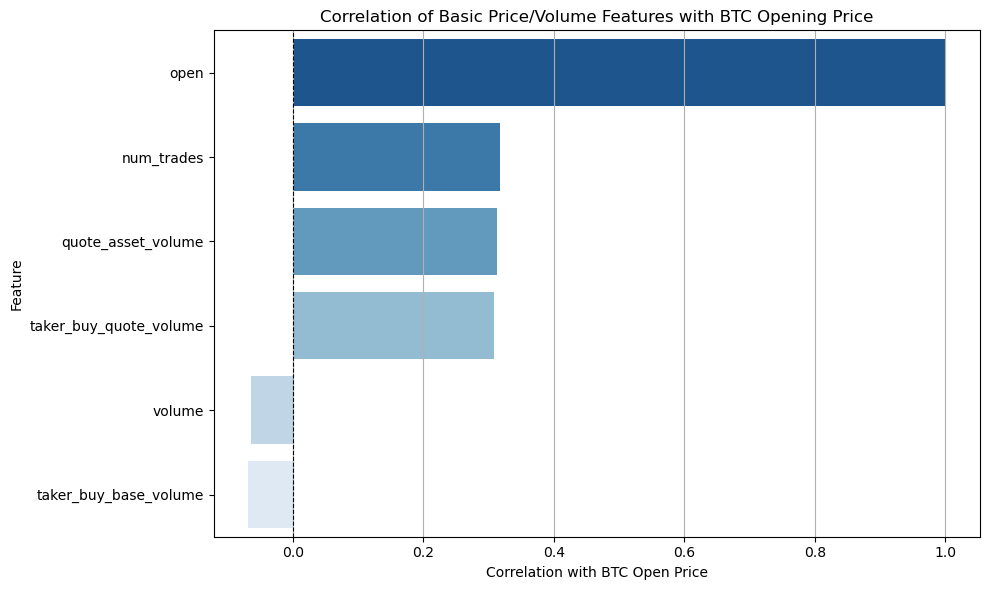

open                      1.000000
num_trades                0.317755
quote_asset_volume        0.313047
taker_buy_quote_volume    0.308761
volume                   -0.065099
taker_buy_base_volume    -0.068260
Name: open, dtype: float64

In [18]:
# Define simple price-related features
price_features = [
    'volume',
    'quote_asset_volume',
    'num_trades',
    'taker_buy_base_volume',
    'taker_buy_quote_volume'
]

# Drop NA rows
df_filtered = df[['open'] + price_features].dropna()

# Compute correlations
price_corr_simple = df_filtered.corr()['open'].sort_values(ascending=False)

# Visualize
plt.figure(figsize=(10, 6))
sns.barplot(x=price_corr_simple.values, y=price_corr_simple.index, palette="Blues_r")
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.title("Correlation of Basic Price/Volume Features with BTC Opening Price")
plt.xlabel("Correlation with BTC Open Price")
plt.ylabel("Feature")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

price_corr_simple

Engineered Features

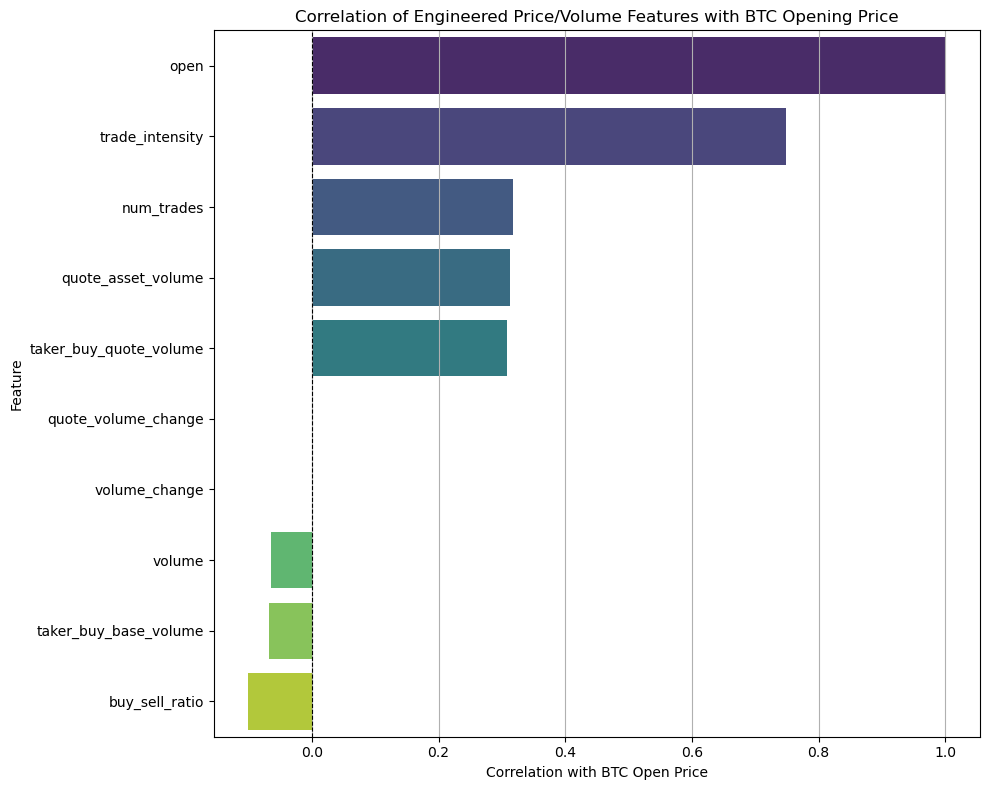

open                      1.000000
trade_intensity           0.748314
num_trades                0.317748
quote_asset_volume        0.313040
taker_buy_quote_volume    0.308754
quote_volume_change       0.002027
volume_change             0.001922
volume                   -0.065110
taker_buy_base_volume    -0.068271
buy_sell_ratio           -0.100286
Name: open, dtype: float64

In [19]:
# Engineer additional features
df['buy_sell_ratio'] = df['taker_buy_base_volume'] / (df['volume'] + 1e-6)
df['trade_intensity'] = df['num_trades'] / (df['volume'] + 1e-6)
df['quote_volume_change'] = df['quote_asset_volume'].pct_change()
df['volume_change'] = df['volume'].pct_change()

# Final list of price-related features including engineered ones
engineered_features = price_features + [
    'buy_sell_ratio',
    'trade_intensity',
    'quote_volume_change',
    'volume_change'
]

# Drop rows with NA due to percentage change
df_filtered = df[['open'] + engineered_features].dropna()

# Compute correlations with BTC opening price
price_corr_engineered = df_filtered.corr()['open'].sort_values(ascending=False)

# Visualize correlations
plt.figure(figsize=(10, 8))
sns.barplot(x=price_corr_engineered.values, y=price_corr_engineered.index, palette="viridis")
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.title("Correlation of Engineered Price/Volume Features with BTC Opening Price")
plt.xlabel("Correlation with BTC Open Price")
plt.ylabel("Feature")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

price_corr_engineered

## 🧠 BTC Trend Classification - Modeling Approach

### 🎯 Goal  
Predict whether **BTC price will go up, down, or stay neutral over the next 24 hours**, using sentiment and market signals from the **past 24 hours**.

---

### 📥 Inputs  
- Hourly data from Reddit, Twitter, Bitcointalk (sentiment)  
- Market features: volume, trades, taker volume, etc.  
- Engineered features:  
  - `trade_intensity = num_trades / volume`  
  - `buy_sell_imbalance = taker_buy_base_volume / volume`  
  - `volume_change`, `quote_volume_change`

---

### 🎯 Label (Target)
- **Future window**: Next 24h average price return  
- **Classes**:  
  - `1` → Up (> +1%)  
  - `-1` → Down (< −1%)  
  - `0` → Neutral (±1%)

---

### 🧱 Model Setup  
- **X**: Past 24h sequence → shape `(24, num_features)`  
- **y**: One label per 48h block (non-overlapping)  
- **Model**: LSTM classifier with softmax output (3 classes)

---

### ✅ Benefits  
- Captures real trend shifts, not noise  
- Prevents label leakage  
- Combines sentiment + price for smarter forecasting  
- Outputs interpretable directional signals
